## EfficientNetV2L (https://arxiv.org/pdf/2104.00298v2.pdf)

In [9]:
!pip install tensorflow_addons --user
!pip install tensorflow_datasets --user
!pip install tensorflow_hub
!pip install tensorflow==2.9.0 --user

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
#import tensorflow_addons as tfa
#import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
#import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

import posixpath

In [2]:
!nvidia-smi

Sun Jul 10 18:49:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
'''

colab= '/content/drive/MyDrive'
local= r'G:\My Drive'

code_runtime= local

'''

In [3]:
tf.__version__

'2.9.0'

In [4]:
#file1= 'thesis/dataset/paddy_doctor/train.csv'
#inp_file = posixpath.join(code_runtime, file1)

train_table=pd.read_csv('train.csv')
train_table

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [5]:
labels=list(np.unique(train_table['label']))
labels

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [8]:
#file2= 'thesis/dataset/paddy_doctor/train_images/'
#img_files= posixpath.join(code_runtime, file2)

train_data= tf.keras.utils.image_dataset_from_directory('train_images',
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        class_names=labels,
                                                        color_mode='rgb',
                                                        image_size=(224,224),
                                                        shuffle=True,
                                                        validation_split=0.2,
                                                        subset='training',
                                                        batch_size= 128,
                                                        seed=42)

val_data= tf.keras.utils.image_dataset_from_directory('train_images',
                                                        labels= 'inferred',
                                                        label_mode='categorical',
                                                        class_names=labels,
                                                        color_mode='rgb',
                                                        image_size=(224,224),
                                                        shuffle=True,
                                                        validation_split=0.2,
                                                        subset='validation',
                                                        batch_size= 128,
                                                        seed=42)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [9]:
# ## Creating data augmentation layer

augmentation_layer= keras.Sequential([
    layers.RandomFlip("horizontal", seed= 42),
    layers.RandomZoom(0.2, 0.2, seed= 42),
    layers.RandomRotation(0.2, seed= 42),
    layers.RandomContrast(0.2, seed= 42)
])

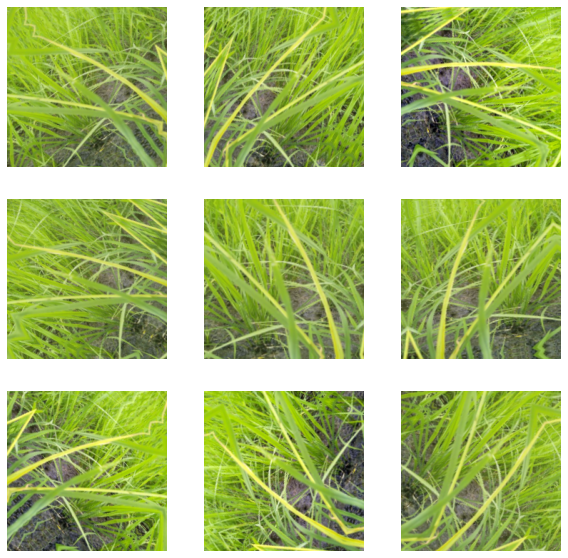

In [10]:
# Checking augmentation

plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
  for i in range(9):
    augmented_images = augmentation_layer(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [11]:
augmented_train_data= train_data.map(
  lambda x, y: (augmentation_layer(x, training=True), y))

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
augmented_train_data= augmented_train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data= val_data.cache().prefetch(buffer_size=AUTOTUNE)

## Modeling

The preprocessing logic has been included in the EfficientNetV2 model implementation. Users are no longer required to call this method to normalize the input data. This method does nothing and only kept as a placeholder to align the API surface between old and new version of model.

In [15]:
def create_model(n_classes):
    inputs= layers.Input(shape = (224, 224, 3))
    conv_base = tf.keras.applications.efficientnet_v2.EfficientNetV2L(include_top = False, 
                                                                      input_tensor = inputs, weights = 'imagenet', 
                                                                      include_preprocessing=True)

    # Freeze the pretrained weights
    conv_base.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name = 'gap')(conv_base.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1024, activation = 'relu')(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(512, activation = 'relu')(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(256, activation = 'relu')(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(128, activation = 'relu')(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(64, activation = 'relu')(x)
    x = layers.Dropout(0.25)(x)
    
    outputs = layers.Dense(n_classes, activation = 'softmax', name = 'pred')(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name = 'EfficientNetv2-L')
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), 
        loss = 'categorical_crossentropy', 
        metrics = ['accuracy'])
    
    return model

model= create_model(10)

In [16]:
n_epochs = 100
#batch_size= 128
#steps_per_epoch= 8326 // batch_size
#validation_steps= 2081 // batch_size

In [ ]:
%%time

filepath= "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint= ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, save_best_only =True, mode= 'max')
callbacks_list= [checkpoint]

history= model.fit(augmented_train_data,
                    epochs= n_epochs,
                    validation_data= val_data,
                    callbacks=callbacks_list,
                    verbose= 1)

Epoch 1/100
12/66 [====>.........................] - ETA: 19:05 - loss: 2.2915 - accuracy: 0.1602

In [ ]:
model.save("paddy_doctor0")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/thesis/dataset/paddy_doctor/paddy_doctor0")

In [ ]:
model.summary()